<a href="https://colab.research.google.com/github/hetkothari/NYC-Taxi-Trip-Capstone-/blob/main/NYC_Taxi_Trip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Problem Description
Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

In [2]:
#Importing the libraries which will be required for this project.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV


#Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
data= pd.read_csv("/content/drive/MyDrive/NYC Taxi Data.csv")

Mounted at /content/drive


#Data Overview

In [5]:
data.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [9]:
data.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [7]:
data.info

<bound method DataFrame.info of                 id  vendor_id  ... store_and_fwd_flag trip_duration
0        id2875421          2  ...                  N           455
1        id2377394          1  ...                  N           663
2        id3858529          2  ...                  N          2124
3        id3504673          2  ...                  N           429
4        id2181028          2  ...                  N           435
...            ...        ...  ...                ...           ...
1458639  id2376096          2  ...                  N           778
1458640  id1049543          1  ...                  N           655
1458641  id2304944          2  ...                  N           764
1458642  id2714485          1  ...                  N           373
1458643  id1209952          1  ...                  N           198

[1458644 rows x 11 columns]>

In [11]:
data["trip_duration"].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

In [15]:
data.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [16]:
data.isnull().sum()


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [18]:
data['pickup'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff'] = pd.to_datetime(data['dropoff_datetime'])

In [26]:
data = data.drop(["pickup_datetime"],axis=1)
data = data.drop(["dropoff_datetime"],axis=1)

In [27]:
data

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup,dropoff
0,id2875421,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14 17:24:55,2016-03-14 17:32:30
1,id2377394,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12 00:43:35,2016-06-12 00:54:38
2,id3858529,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19 11:35:24,2016-01-19 12:10:48
3,id3504673,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06 19:32:31,2016-04-06 19:39:40
4,id2181028,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26 13:30:55,2016-03-26 13:38:10
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08 13:31:04,2016-04-08 13:44:02
1458640,id1049543,1,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10 07:35:15,2016-01-10 07:46:10
1458641,id2304944,2,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22 06:57:41,2016-04-22 07:10:25
1458642,id2714485,1,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05 15:56:26,2016-01-05 16:02:39


In [29]:
from geopy.distance import great_circle
def cal_distance(pickup_lat,pickup_long,dropoff_lat,dropoff_long):
 
 start_coordinates=(pickup_lat,pickup_long)
 stop_coordinates=(dropoff_lat,dropoff_long)
 
 return great_circle(start_coordinates,stop_coordinates).km

In [30]:
data['distance'] = data.apply(lambda x: cal_distance(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude'] ), axis=1)

In [32]:
data['speed'] = (data.distance/(data.trip_duration/3600))

In [33]:
dummy = pd.get_dummies(data.store_and_fwd_flag, prefix='store_and_fwd_flag')
data = pd.concat([data,dummy], axis = 1)

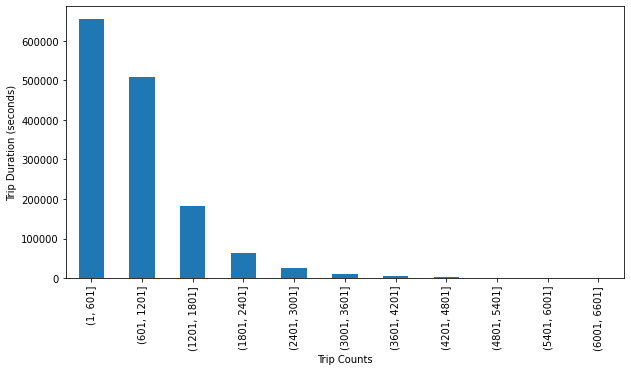

In [38]:
plt.figure(figsize = (10,5))
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,7200,600))).count().plot(kind='bar')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()


In [39]:
data = data[data.trip_duration <= 4200]
data = data[data.trip_duration >= 60]

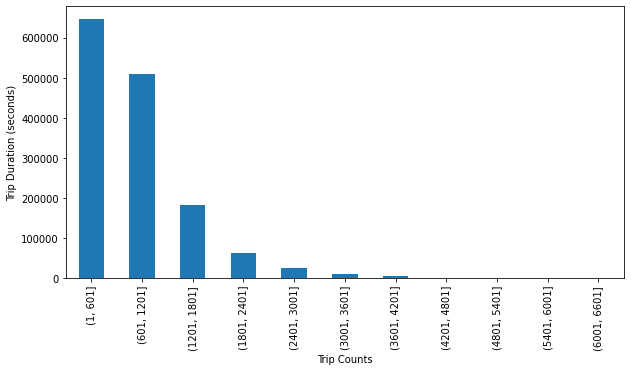

In [40]:
plt.figure(figsize = (10,5))
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,7200,600))).count().plot(kind='bar')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()


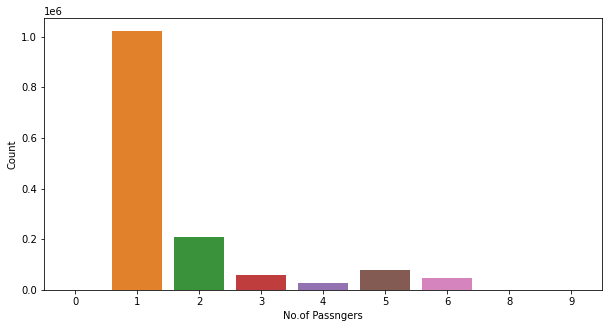

In [41]:
plt.figure(figsize = (10,5))
sns.countplot(x='passenger_count',data=data)
plt.ylabel('Count')
plt.xlabel('No.of Passngers')
plt.show()

In [42]:
data['store_and_fwd_flag'].value_counts(normalize=True)

N    0.9946
Y    0.0054
Name: store_and_fwd_flag, dtype: float64

In [44]:
data=data.drop(["store_and_fwd_flag"],axis=1)

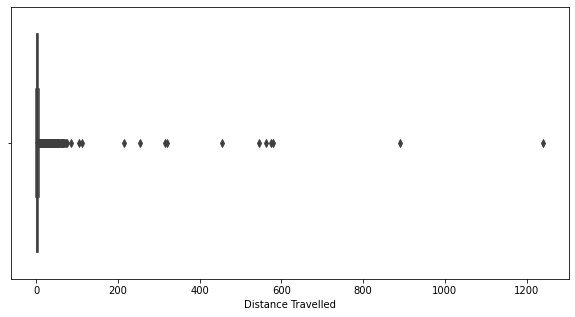

In [45]:
plt.figure(figsize = (10,5))
sns.boxplot(data.distance)
plt.xlabel('Distance Travelled')
plt.show()

In [46]:
data = data[~(data.distance > 80)]
data = data[~(data.distance < 2)]

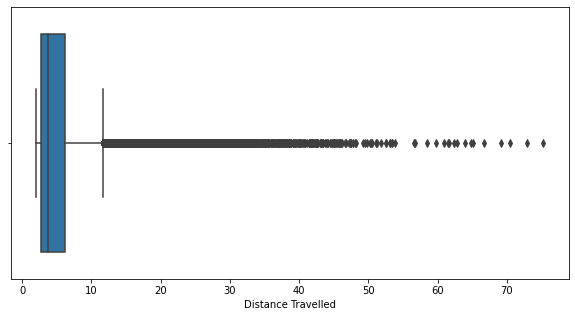

In [47]:
plt.figure(figsize = (10,5))
sns.boxplot(data.distance)
plt.xlabel('Distance Travelled')
plt.show()

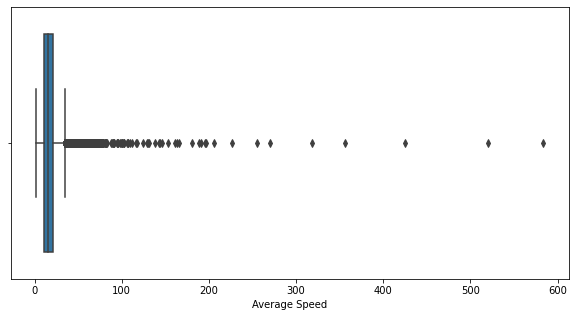

In [48]:
plt.figure(figsize = (10,5))
sns.boxplot(data.speed)
plt.xlabel('Average Speed')
plt.show()

In [49]:
data = data[~(data.speed >40)]

In [50]:
data.info

<bound method DataFrame.info of                 id  vendor_id  ...  store_and_fwd_flag_N  store_and_fwd_flag_Y
2        id3858529          2  ...                     1                     0
7        id1324603          2  ...                     1                     0
9        id0012891          2  ...                     1                     0
10       id1436371          2  ...                     1                     0
11       id1299289          2  ...                     1                     0
...            ...        ...  ...                   ...                   ...
1458634  id3445276          1  ...                     1                     0
1458637  id1920898          1  ...                     1                     0
1458638  id1454193          2  ...                     1                     0
1458640  id1049543          1  ...                     1                     0
1458641  id2304944          2  ...                     1                     0

[741421 rows x 16 c